# Trustworthy Agents with LangGraph and Cleanlab

<head>
  <meta name="title" content="Trustworthy Agents with LangGraph and Cleanlab"/>
  <meta property="og:title" content="Trustworthy Agents with LangGraph and Cleanlab"/>
  <meta name="twitter:title" content="Trustworthy Agents with LangGraph and Cleanlab" />
  <meta name="description" content="How to prevent incorrect responses from your agentic AI."  />
  <meta property="og:description" content="How to prevent incorrect responses from your agentic AI." />
  <meta name="twitter:description" content="How to prevent incorrect responses from your agentic AI." />
</head>

Agentic AI applications — such as those built with [LangGraph](https://www.langchain.com/langgraph) — can chain together multiple tools and LLM calls to answer complex user queries. However due to LLM hallucinations, Agents occasionally produce incorrect responses, which erodes user trust and production readiness. This tutorial demonstrates how to score the trustworthiness of responses from any LangGraph Agent in real-time, and prevent incorrect responses from being served to your users.

## Setup

In [ ]:
# Install required packages
%pip install cleanlab-tlm langgraph langchain langchain_openai

In [ ]:
# Set API keys
import os
os.environ["CLEANLAB_TLM_API_KEY"] = "<YOUR_CLEANLAB_TLM_API_KEY>"  # Get your free API key from: https://tlm.cleanlab.ai/
os.environ["OPENAI_API_KEY"] = "<YOUR_OPENAI_API_KEY>" # Get API key from: https://platform.openai.com/signup

In [ ]:
# Import required libraries
import langgraph
from cleanlab_tlm import TLM

## Build a LangGraph Agent

Here we build on LangGraph’s [Customer Support Bot](https://langchain-ai.github.io/langgraph/tutorials/customer-support/customer-support/) tutorial, which you should refer to learn more about building Agents with LangGraph.

Our customer support Agent will be able to use various read-only Tools (functions without irreversible side-effects) in order to gather necessary information before answering the user. This tutorial shows how to automatically detect when the Agent's answer is untrustworthy (likely incorrect). Other agentic AI applications where you can apply the same code demonstrated here include: Research Agents (DeepResearch), AI Analysts, Advisor Agents, Sales/Marketing Agents, Data Processing Agents, i.e. applications where the Agent's response must be accurate.

These applications are different than *task-oriented* Agents whose sole job is to execute some Tool(s) (often an irreversible operation like writing in a calendar) rather than giving the user an accurate and informative answer. For *task-oriented* Agents, we instead recommend scoring the trustworthiness of *every* internal Agent output (LLM call) to prevent mistakes before an irreversible Tool is called.

**Optional: Populate Database that Agent can access via Tool Call**



In [ ]:
import os
import shutil
import sqlite3

import pandas as pd
import requests

from datetime import timedelta

db_url = "https://storage.googleapis.com/benchmarks-artifacts/travel-db/travel2.sqlite"
local_file = "travel2.sqlite"
# The backup lets us restart for each tutorial section
backup_file = "travel2.backup.sqlite"
overwrite = False
if overwrite or not os.path.exists(local_file):
    response = requests.get(db_url)
    response.raise_for_status()  # Ensure the request was successful
    with open(local_file, "wb") as f:
        f.write(response.content)
    # Backup - we will use this to "reset" our DB in each section
    shutil.copy(local_file, backup_file)


# Convert the flights to present time for our tutorial
def update_dates(file):
    shutil.copy(backup_file, file)
    conn = sqlite3.connect(file)
    cursor = conn.cursor()

    tables = pd.read_sql(
        "SELECT name FROM sqlite_master WHERE type='table';", conn
    ).name.tolist()
    tdf = {}
    for t in tables:
        tdf[t] = pd.read_sql(f"SELECT * from {t}", conn)

    example_time = pd.to_datetime(
        tdf["flights"]["actual_departure"].replace("\\N", pd.NaT)
    ).max()
    current_time = pd.to_datetime("now").tz_localize(example_time.tz)
    time_diff = current_time - example_time

    tdf["bookings"]["book_date"] = (
        pd.to_datetime(tdf["bookings"]["book_date"].replace("\\N", pd.NaT), utc=True)
        + time_diff
    )

    datetime_columns = [
        "scheduled_departure",
        "scheduled_arrival",
        "actual_departure",
        "actual_arrival",
    ]
    for column in datetime_columns:
        tdf["flights"][column] = (
            pd.to_datetime(tdf["flights"][column].replace("\\N", pd.NaT)) + time_diff
        )

    for table_name, df in tdf.items():
        df.to_sql(table_name, conn, if_exists="replace", index=False)
    del df
    del tdf
    conn.commit()
    conn.close()

    return file


db = update_dates(local_file)

**Optional: Define the available Tools**



In [ ]:
import re

import numpy as np
import openai
import requests
from langchain_core.tools import tool

response = requests.get(
    "https://storage.googleapis.com/benchmarks-artifacts/travel-db/swiss_faq.md"
)
response.raise_for_status()
faq_text = response.text

docs = [{"page_content": txt} for txt in re.split(r"(?=\n##)", faq_text)]

class VectorStoreRetriever:
    def __init__(self, docs: list, vectors: list, oai_client):
        self._arr = np.array(vectors)
        self._docs = docs
        self._client = oai_client

    @classmethod
    def from_docs(cls, docs, oai_client):
        embeddings = oai_client.embeddings.create(
            model="text-embedding-3-small", input=[doc["page_content"] for doc in docs]
        )
        vectors = [emb.embedding for emb in embeddings.data]
        return cls(docs, vectors, oai_client)

    def query(self, query: str, k: int = 5) -> list[dict]:
        embed = self._client.embeddings.create(
            model="text-embedding-3-small", input=[query]
        )
        # "@" is just a matrix multiplication in python
        scores = np.array(embed.data[0].embedding) @ self._arr.T
        top_k_idx = np.argpartition(scores, -k)[-k:]
        top_k_idx_sorted = top_k_idx[np.argsort(-scores[top_k_idx])]
        return [
            {**self._docs[idx], "similarity": scores[idx]} for idx in top_k_idx_sorted
        ]


retriever = VectorStoreRetriever.from_docs(docs, openai.Client())

@tool
def lookup_policy(query: str) -> str:
    """Consult the company policies to check whether certain options are permitted.
    Use this before making any flight changes performing other 'write' events."""
    docs = retriever.query(query, k=2)
    return "\n\n".join([doc["page_content"] for doc in docs])

import sqlite3
from datetime import date, datetime
from typing import Optional

import pytz
from langchain_core.runnables import RunnableConfig

@tool
def fetch_user_flight_information(config: RunnableConfig) -> list[dict]:
    """Fetch all tickets for the user along with corresponding flight information and seat assignments.

    Returns:
        A list of dictionaries where each dictionary contains the ticket details,
        associated flight details, and the seat assignments for each ticket belonging to the user.
    """
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = """
    SELECT
        t.ticket_no, t.book_ref,
        f.flight_id, f.flight_no, f.departure_airport, f.arrival_airport, f.scheduled_departure, f.scheduled_arrival,
        bp.seat_no, tf.fare_conditions
    FROM
        tickets t
        JOIN ticket_flights tf ON t.ticket_no = tf.ticket_no
        JOIN flights f ON tf.flight_id = f.flight_id
        JOIN boarding_passes bp ON bp.ticket_no = t.ticket_no AND bp.flight_id = f.flight_id
    WHERE
        t.passenger_id = ?
    """
    cursor.execute(query, (passenger_id,))
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results

from datetime import date, datetime
from typing import Optional, Union

@tool
def search_flights(
    departure_airport: Optional[str] = None,
    arrival_airport: Optional[str] = None,
    start_time: Optional[date | datetime] = None,
    end_time: Optional[date | datetime] = None,
    limit: int = 20,
) -> list[dict]:
    """Search for flights based on departure airport, arrival airport, and departure time range."""
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM flights WHERE 1 = 1"
    params = []

    if departure_airport:
        query += " AND departure_airport = ?"
        params.append(departure_airport)

    if arrival_airport:
        query += " AND arrival_airport = ?"
        params.append(arrival_airport)

    if start_time:
        query += " AND scheduled_departure >= ?"
        params.append(start_time)

    if end_time:
        query += " AND scheduled_departure <= ?"
        params.append(end_time)
    query += " LIMIT ?"
    params.append(limit)
    cursor.execute(query, params)
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results

@tool
def search_car_rentals(
    location: Optional[str] = None,
    name: Optional[str] = None,
    price_tier: Optional[str] = None,
    start_date: Optional[Union[datetime, date]] = None,
    end_date: Optional[Union[datetime, date]] = None,
) -> list[dict]:
    """
    Search for car rentals based on location, name, price tier, start date, and end date.

    Args:
        location (Optional[str]): The location of the car rental. Defaults to None.
        name (Optional[str]): The name of the car rental company. Defaults to None.
        price_tier (Optional[str]): The price tier of the car rental. Defaults to None.
        start_date (Optional[Union[datetime, date]]): The start date of the car rental. Defaults to None.
        end_date (Optional[Union[datetime, date]]): The end date of the car rental. Defaults to None.

    Returns:
        list[dict]: A list of car rental dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM car_rentals WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    if price_tier:
        query += " AND price_tier LIKE ?"
        params.append(f"%{price_tier}%")
    if start_date:
        query += " AND start_date >= ?"
        params.append(str(start_date))
    if end_date:
        query += " AND end_date <= ?"
        params.append(str(end_date))
    # We allow matching on price tier and dates even though data is limitted
    # to test agent behavior when relevant data might be missing.
    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]

@tool
def search_hotels(
    location: Optional[str] = None,
    name: Optional[str] = None,
    price_tier: Optional[str] = None,
    checkin_date: Optional[Union[datetime, date]] = None,
    checkout_date: Optional[Union[datetime, date]] = None,
) -> list[dict]:
    """
    Search for hotels based on location, name, price tier, check-in date, and check-out date.

    Args:
        location (Optional[str]): The location of the hotel. Defaults to None.
        name (Optional[str]): The name of the hotel. Defaults to None.
        price_tier (Optional[str]): The price tier of the hotel. Defaults to None. Examples: Midscale, Upper Midscale, Upscale, Luxury
        checkin_date (Optional[Union[datetime, date]]): The check-in date of the hotel. Defaults to None.
        checkout_date (Optional[Union[datetime, date]]): The check-out date of the hotel. Defaults to None.

    Returns:
        list[dict]: A list of hotel dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM hotels WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    # For the sake of this tutorial, we will let you match on any dates and price tier.
    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]

@tool
def search_trip_recommendations(
    location: Optional[str] = None,
    name: Optional[str] = None,
    keywords: Optional[str] = None,
) -> list[dict]:
    """
    Search for trip recommendations based on location, name, and keywords.

    Args:
        location (Optional[str]): The location of the trip recommendation. Defaults to None.
        name (Optional[str]): The name of the trip recommendation. Defaults to None.
        keywords (Optional[str]): The keywords associated with the trip recommendation. Defaults to None.

    Returns:
        list[dict]: A list of trip recommendation dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM trip_recommendations WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    if keywords:
        keyword_list = keywords.split(",")
        keyword_conditions = " OR ".join(["keywords LIKE ?" for _ in keyword_list])
        query += f" AND ({keyword_conditions})"
        params.extend([f"%{keyword.strip()}%" for keyword in keyword_list])

    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


# Some additional tools beyond those from LangGraph's original tutorial

@tool
def get_travel_advisory(country: str) -> dict:
    """Returns a mock travel advisory for a country."""
    return {
        "level": "Level 2 – Exercise Increased Caution",
        "notes": f"Travelers to {country} should be aware of petty crime and take precautions."
    }

@tool
def get_discount_plan(name: str) -> str:
    """Returns details about a discount plan based on its name.

    Valid names: "basic", "premium", "five", "student"
    """
    return f"Returning details for the '{name}' discount plan:"

class InsuranceTerms:
    def __init__(self, provider: str):
        self.provider = provider
        self.coverage = {
            "GloboSure": {
                "trip_delay": "Up to 500 credits after 6 hours",
                "lost_baggage": "Up to 1200 credits with receipt proof",
                "medical": "Emergency care covered up to 50,000 credits"
            },
            "NimbusCoverage": {
                "cancellation": "Refunds up to 70% for non-weather issues",
                "extreme_weather": "Full coverage with documentation"
            }
        }

@tool
def get_insurance_terms(provider: str) -> InsuranceTerms:
    """Returns a policy explanation object for a given (possibly obscure) travel insurance provider."""
    return InsuranceTerms(provider)

**Optional: Helper methods to support Tool invocation**



In [ ]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

    ## Added to print trust scores
    print()
    trust_score = event.get("trustworthiness_score")
    if trust_score is not None:
        print(f"[TLM score for this response]: {trust_score:.2f}")

**Optional: Setup LangGraph State**



In [ ]:
from typing import Annotated, Optional
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    # State follows the structure from the original LangGraph tutorial, plus an optional trustworthiness_score field
    messages: Annotated[list[AnyMessage], add_messages]
    trustworthiness_score: Optional[float]  # Later in this tutorial, we will store trust scores here, but they are not required for the original LangGraph Agent

**Optional: Setup LangGraph Agent**



In [ ]:
from datetime import datetime
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            passenger_id = configuration.get("passenger_id", None)
            state = {**state, "user_info": passenger_id}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

llm = ChatOpenAI(model="gpt-4o-mini")

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for Swiss Airlines. "
            " Use the provided tools to search for flights, company policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

part_1_tools = [
    fetch_user_flight_information,
    search_flights,
    lookup_policy,
    search_car_rentals,
    search_hotels,
    search_trip_recommendations,
    # Additional mock tools
    get_travel_advisory,
    get_discount_plan,
    get_insurance_terms,
]

part_1_assistant_runnable = primary_assistant_prompt | llm.bind_tools(part_1_tools)

**Optional: Setup LangGraph Graph**



In [ ]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)

# Define nodes: these do the work
builder.add_node("assistant", Assistant(part_1_assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(part_1_tools))
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state, a complete memory for the entire graph
# memory = MemorySaver()
# part_1_graph = builder.compile(checkpointer=memory)

# This tutorial focuses solely on single-turn Question-Answer interactions between user and assistant.
part_1_graph = builder.compile()


# Method to query the Agent we implemented via this graph
def run_conversation(graph, question):

    _printed = set()

    events = graph.stream(
        {"messages": ("user", question)},
        RunnableConfig(configurable={"passenger_id": "3442 587242"}),
        stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)

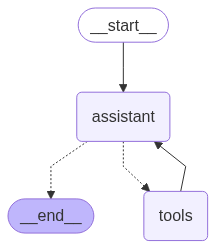

In [ ]:
from IPython.display import Image, display

try:
    display(Image(part_1_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass  # This requires some extra dependencies and is optional

If you have any questions about the LangGraph code, refer to their [tutorial](https://langchain-ai.github.io/langgraph/tutorials/customer-support/customer-support/) and documentation.

## Run the Agent

Let's ask our customer support Agent some queries.

In [ ]:
easy_question = "Can I get a refund if I cancel my flight with Swiss Airlines?"

run_conversation(
    graph=part_1_graph,
    question=easy_question
)

================================ Human Message =================================

Can I get a refund if I cancel my flight with Swiss Airlines?

================================== Ai Message ==================================
Tool Calls:
  lookup_policy (call_EEGeKY4P1B9W86XNYjCUnVKv)
 Call ID: call_EEGeKY4P1B9W86XNYjCUnVKv
  Args:
    query: refund policy for flight cancellations

================================= Tool Message =================================
Name: lookup_policy


## How to Cancel a Swiss Air Flight: 877-5O7-7341 Step-by-Step Guide
Swiss Air is a premium airline based in Switzerland that offers a range of domestic and international flights to passengers. However, sometimes situations arise where passengers may need to cancel their flights. In such cases, it is important to understand the Swiss Air Cancellation Policy to avoid any confusion or additional charges.

Swiss International Airlines Cancellation Policy
In this article, we will provide you with everything you

This example illustrates the agent’s ability to call the appropriate tool and craft an accurate, policy-based answer from the returned data. In the rest of this section, we will dial in on problematic responses.

In [ ]:
incomplete_tool = "What are the details of the 5 discount plan"

run_conversation(
    graph=part_1_graph,
    question=incomplete_tool
)

================================ Human Message =================================

What are the details of the 5 discount plan
================================== Ai Message ==================================
Tool Calls:
  get_discount_plan (call_ZNGt6LgLkmVDH5amJTp6Nt1V)
 Call ID: call_ZNGt6LgLkmVDH5amJTp6Nt1V
  Args:
    name: five
================================= Tool Message =================================
Name: get_discount_plan

Returning details for the 'five' discount plan:
================================== Ai Message ==================================

Here are the details for the "five" discount plan:

- **Discount Level**: 5% off on all flights.
- **Eligibility**: Available for all customers.
- **Validity**: The discount can be applied to any flight booked through Swiss Airlines.
- **Usage**: Can be used multiple times, but must be specified at the time of booking.
- **Exclusions**: Not applicable on promotional fares or during special sales.

If you have any more question

The tool message here was intentionally left incomplete. With no real details to draw on, the LLM hallucinated details about the discount plan, potentially misleading users.

In [ ]:
tool_returns_object = "What coverage does GloboSure give me for travel delays?"

run_conversation(
    graph=part_1_graph,
    question=tool_returns_object
)

================================ Human Message =================================

What coverage does GloboSure give me for travel delays?
================================== Ai Message ==================================
Tool Calls:
  get_insurance_terms (call_vlr2b82vZcZSsor1KgMHoRs9)
 Call ID: call_vlr2b82vZcZSsor1KgMHoRs9
  Args:
    provider: GloboSure
================================= Tool Message =================================
Name: get_insurance_terms

================================== Ai Message ==================================

GloboSure provides coverage for travel delays as follows:

- **Delayed Departure**: If your scheduled departure is delayed for more than a specified number of hours, GloboSure may cover additional expenses for meals, accommodation, and transportation.
  
- **Reimbursement**: They typically offer reimbursement for reasonable and necessary expenses incurred due to the delay. The amount and type of expenses covered can vary, so it is essential to keep 

Here, a tool bug returned only a raw Python object, so the LLM filled the gap by hallucinating travel-delay coverage details.

In [ ]:
irrelevant_tool_response = "Is there a health advisory in Basel"

run_conversation(
    graph=part_1_graph,
    question=irrelevant_tool_response
)

================================ Human Message =================================

Is there a health advisory in Basel

================================== Ai Message ==================================
Tool Calls:
  get_travel_advisory (call_sYnHcsE2MmLZ6omkIEMS9I5u)
 Call ID: call_sYnHcsE2MmLZ6omkIEMS9I5u
  Args:
    country: Switzerland

================================= Tool Message =================================
Name: get_travel_advisory

{"level": "Level 2 – Exercise Increased Caution", "notes": "Travelers to Switzerland should be aware of petty crime and take precautions."}

================================== Ai Message ==================================

There is a health advisory for Switzerland, including Basel:

- **Advisory Level**: Level 2 – Exercise Increased Caution
- **Notes**: Travelers are advised to be aware of petty crime and take necessary precautions.

If you need further information or specific health-related advice, feel free to ask!



Although the agent chose the correct tool, it returned an advisory about crime rather than the requested health advisory for Basel. It failed to explain that it did not have the relevant information.

In [ ]:
time_zone_issue = "What is my arrival time in their time zone?"

run_conversation(
    graph=part_1_graph,
    question=time_zone_issue
)

================================ Human Message =================================

What is my arrival time in their time zone?
================================== Ai Message ==================================
Tool Calls:
  fetch_user_flight_information (call_xglItw1ZVFdk01CAM4xmxmzM)
 Call ID: call_xglItw1ZVFdk01CAM4xmxmzM
  Args:
================================= Tool Message =================================
Name: fetch_user_flight_information

[{"ticket_no": "7240005432906569", "book_ref": "C46E9F", "flight_id": 19250, "flight_no": "LX0112", "departure_airport": "CDG", "arrival_airport": "BSL", "scheduled_departure": "2025-05-30 01:36:24.169593-04:00", "scheduled_arrival": "2025-05-30 03:06:24.169593-04:00", "seat_no": "18E", "fare_conditions": "Economy"}]
================================== Ai Message ==================================

Your flight LX0112 from Paris Charles de Gaulle (CDG) to EuroAirport Basel-Mulhouse-Freiburg (BSL) is scheduled to arrive at **03:06 AM** (local time)

The assistant mistakenly assumed Basel (BSL) used the UTC-4 time zone. In May, Basel observes Central European Summer Time (UTC+2), so the correct local arrival time should be six hours later than stated.

In [ ]:
no_tool_issue = "What are conspiracy theories around Swiss Airlines safety?"

run_conversation(
    graph=part_1_graph,
    question=no_tool_issue
)

================================ Human Message =================================

What are conspiracy theories around Swiss Airlines safety?

================================== Ai Message ==================================

While conspiracy theories regarding airlines can circulate, it's important to note that many of these theories are based on misinformation or speculation rather than factual evidence. Some common themes associated with conspiracy theories surrounding airline safety, including Swiss Airlines, might involve:

1. **Cover-ups**: Some individuals may claim that airlines cover up accidents or incidents to protect their reputations. This can include everything from technical failures to security breaches.

2. **Sabotage**: There are occasionally unfounded theories suggesting that flights could be sabotaged for various reasons, often without any grounding in fact.

3. **Political Motives**: Conspiracy theories may suggest that certain flights are targeted due to political i

No appropriate tool is available for this query, yet the assistant responds with a potentially hallucinated answer that could further harm the airline’s reputation.

## Trustworthy Agent

Now let's see how Cleanlab's [Trustworthy Language Model](https://cleanlab.ai/blog/trustworthy-language-model/) (TLM) can catch these issues in real time via state-of-the-art LLM trustworthiness scoring. Easily integrate TLM into your LangGraph application by wrapping your existing assistant (LLM) node with our provided wrapper. This will update the LangGraph state with a score quantifying the trustworthiness of the latest AI message, such that low scores correspond to messages which are likely incorrect or otherwise flawed.

We first initialize a Cleanlab client.

In [ ]:
tlm = TLM()  # See Advanced Tutorial for optional TLM configurations to get better/faster results

In [ ]:
class TrustworthyAssistant:
    def __init__(self, assistant: Assistant, tools, tlm):
        self.assistant = assistant
        self.tools = tools
        self.tlm = tlm

    def __call__(self, state: State, config: RunnableConfig):

        # Render full prompt including system which uses template variables
        # TODO: Update this based on your ChatPromptTemplate
        configuration = config.get("configurable", {})
        passenger_id = configuration.get("passenger_id", None)
        state = {**state, "user_info": passenger_id}
        prompt_template = self.assistant.runnable.first
        full_prompt_messages = prompt_template.invoke(state)

        # Run the assistant node
        result_dict = self.assistant(state, config)
        result = result_dict["messages"]

        # Convert chat history and tools to OpenAI format
        from langchain_core.messages.utils import convert_to_openai_messages
        from langchain_core.utils.function_calling import convert_to_openai_tool
        from cleanlab_tlm.utils.chat import form_prompt_string

        openai_chat_history = convert_to_openai_messages(full_prompt_messages)
        openai_response_msg = convert_to_openai_messages(result)
        openai_chat_tools = [convert_to_openai_tool(tool) for tool in self.tools]

        # Only score assistant messages with content
        if openai_response_msg.get("role") == "assistant" and openai_response_msg.get("content"):
            prompt = form_prompt_string(openai_chat_history, openai_chat_tools)
            response = openai_response_msg["content"]
            score = self.tlm.get_trustworthiness_score(prompt=prompt, response=response)["trustworthiness_score"]
        else:
            score = None

        return {**result_dict, "trustworthiness_score": score}

After adding the wrapper node, simply re-compile your LangGraph. You only update a single line of code—everything else can stay exactly the same.

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)

# Define nodes: these do the work
builder.add_node("assistant", TrustworthyAssistant(Assistant(part_1_assistant_runnable), part_1_tools, tlm)) # ONLY CHANGE NEEDED.
builder.add_node("tools", create_tool_node_with_fallback(part_1_tools))
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

tlm_graph = builder.compile()

The graph implementing our Agent remains unchanged.

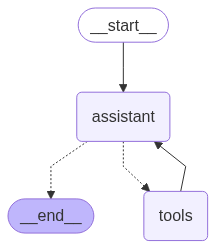

In [ ]:
from IPython.display import Image, display

try:
    display(Image(tlm_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now let's run our Agent with automated trustworthiness scoring in place.
In the traces below, the trustworthiness scores from TLM correspond to the **final assistant message** in each conversation. This is the response given to your user, whose correctness is vital.

In [ ]:
easy_question = "Can I get a refund if I cancel my flight with Swiss Airlines?"

run_conversation(
    graph=tlm_graph,
    question=easy_question
)

================================ Human Message =================================

Can I get a refund if I cancel my flight with Swiss Airlines?

================================== Ai Message ==================================
Tool Calls:
  lookup_policy (call_jhd1PuqSiBZJRNRpll83KTvn)
 Call ID: call_jhd1PuqSiBZJRNRpll83KTvn
  Args:
    query: refund policy for canceling flight

================================= Tool Message =================================
Name: lookup_policy


## How to Cancel a Swiss Air Flight: 877-5O7-7341 Step-by-Step Guide
Swiss Air is a premium airline based in Switzerland that offers a range of domestic and international flights to passengers. However, sometimes situations arise where passengers may need to cancel their flights. In such cases, it is important to understand the Swiss Air Cancellation Policy to avoid any confusion or additional charges.

Swiss International Airlines Cancellation Policy
In this article, we will provide you with everything you nee

Upon closer review, we see that the Agent's response was correct for this simple question. TLM computed a high trustworthiness score in real-time, letting our application serve this response to users with great confidence.

In [ ]:
incomplete_tool = "What are the details of the 5 discount plan"

run_conversation(
    graph=tlm_graph,
    question=incomplete_tool
)

================================ Human Message =================================

What are the details of the 5 discount plan

================================== Ai Message ==================================
Tool Calls:
  get_discount_plan (call_Y5Sln7B2KBg2aFROpdKnms4Z)
 Call ID: call_Y5Sln7B2KBg2aFROpdKnms4Z
  Args:
    name: five

================================= Tool Message =================================
Name: get_discount_plan

Returning details for the 'five' discount plan:

================================== Ai Message ==================================

Here are the details of the "five" discount plan:

- **Discount Rate**: 5% off on all flights.
- **Eligibility**: Available for all travelers.
- **Validity**: The discount is applicable for bookings made at least 5 days in advance.
- **Usage**: This discount can be combined with other promotional offers.
- **Booking Channels**: Available for use on the Swiss Airlines website and mobile app.

If you have any other questions 

In [ ]:
tool_returns_object = "What coverage does GloboSure give me for travel delays?"

run_conversation(
    graph=tlm_graph,
    question=tool_returns_object
)

================================ Human Message =================================

What coverage does GloboSure give me for travel delays?

================================== Ai Message ==================================
Tool Calls:
  get_insurance_terms (call_5HBMrsu9VniT5yy0C6869d7z)
 Call ID: call_5HBMrsu9VniT5yy0C6869d7z
  Args:
    provider: GloboSure

================================= Tool Message =================================
Name: get_insurance_terms


================================== Ai Message ==================================

The coverage provided by GloboSure for travel delays typically includes:

1. **Trip Interruption**: Compensation for expenses incurred if your trip is interrupted due to covered reasons.
   
2. **Accommodation and Meal Expenses**: Reimbursement for additional accommodation and meal costs if you have to stay longer than planned due to delays.

3. **Transportation Costs**: Coverage for unexpected transportation costs caused by a delay.

4. **Lost W

In [ ]:
irrelevant_tool_response = "Is there a health advisory in Basel"

run_conversation(
    graph=tlm_graph,
    question=irrelevant_tool_response
)

================================ Human Message =================================

Is there a health advisory in Basel

================================== Ai Message ==================================
Tool Calls:
  get_travel_advisory (call_4cUzHKkhbDesWTkZ1wpSof8Z)
 Call ID: call_4cUzHKkhbDesWTkZ1wpSof8Z
  Args:
    country: Switzerland

================================= Tool Message =================================
Name: get_travel_advisory

{"level": "Level 2 – Exercise Increased Caution", "notes": "Travelers to Switzerland should be aware of petty crime and take precautions."}

================================== Ai Message ==================================

There is a health advisory for Switzerland, which includes Basel. The advisory level is **Level 2 – Exercise Increased Caution**. Travelers are advised to be aware of petty crime and to take necessary precautions while traveling in the area.

[TLM score for this response]: 0.72


In [ ]:
time_zone_issue = "What is my arrival time in their time zone?"

run_conversation(
    graph=tlm_graph,
    question=time_zone_issue
)

================================ Human Message =================================

What is my arrival time in their time zone?

================================== Ai Message ==================================
Tool Calls:
  fetch_user_flight_information (call_erMS3rPidqO5MH9l3su1dQx8)
 Call ID: call_erMS3rPidqO5MH9l3su1dQx8
  Args:

================================= Tool Message =================================
Name: fetch_user_flight_information

[{"ticket_no": "7240005432906569", "book_ref": "C46E9F", "flight_id": 19250, "flight_no": "LX0112", "departure_airport": "CDG", "arrival_airport": "BSL", "scheduled_departure": "2025-06-04 16:34:21.797505-04:00", "scheduled_arrival": "2025-06-04 18:04:21.797505-04:00", "seat_no": "18E", "fare_conditions": "Economy"}]

================================== Ai Message ==================================

Your flight LX0112 is scheduled to arrive at EuroAirport Basel-Mulhouse-Freiburg (BSL) on June 4, 2025, at 18:04 local time (UTC+2).

[TLM score fo

In [ ]:
no_tool_issue = "What are conspiracy theories around Swiss Airlines safety?"

run_conversation(
    graph=tlm_graph,
    question=no_tool_issue
)

================================ Human Message =================================

What are conspiracy theories around Swiss Airlines safety?

================================== Ai Message ==================================

While I don't have direct access to news articles or a database of conspiracy theories, I can summarize a few general themes surrounding conspiracy theories related to airlines, including Swiss Airlines:

1. **False Flag Operations**: Some conspiracy theorists suggest that certain airline accidents or incidents are orchestrated government actions to justify wider political or military agendas. 

2. **Safety Records**: Some critics question the safety records of specific airlines, alleging that certain incidents are covered up or not thoroughly investigated, calling into question the true safety of air travel.

3. **Technological Manipulation**: Theories sometimes suggest that aircraft technology or systems can be remotely manipulated, leading to accidents or inciden

Upon closer review, we see that the Agent's responses were problematic for the above queries. These responses received lower trustworthiness scores from TLM, allowing our application to flag them in real-time.

You could still choose to show such responses to users appending a caveat like: `CAUTION: THIS RESPONSE HAS BEEN FLAGGED AS POTENTIALLY UNTRUSTWORTHY`. Alternatively, you could escalate this interaction to a human customer support representative, or return a canned fallback response in place of the Agent's response. The next section demonstrates how to implement the fallback strategy in LangGraph.

## Fallback Logic: Replacing Untrustworthy Responses

To enable your agent to act on the trustworthiness score, you can create a fallback node. Here we use a simple fallback node which replaces the original assistant message with a pre-written response that indicates a lack of knowledge.

You can easily swap this out for other fallback behaviors such as: escalating to a human, triggering a reviser node, or re-running the Agent with a modified prompt (possibly incorporating past untrustworthy responses).

**Important:** Since the trustworthiness score in the LangGraph `state` should reflect the most recent assistant message, set it to `None` in your fallback node to prevent the fallback condition from repeatedly triggering.

In [ ]:
from langchain_core.messages import RemoveMessage

def fallback_node(state):
    messages = state["messages"]
    if not messages:
        return state  # Nothing to remove

    # Remove the last message
    to_remove = RemoveMessage(id=messages[-1].id)

    # Add a new assistant message
    new_msg = {
            "role": "assistant",
            "content": "I'm not confident in answering this question. Let's try something else or rephrase the question."
    }

    return {
        **state,
        "messages": [to_remove, new_msg],
        "trustworthiness_score": None
    }

This function defines conditional logic for routing based on the trustworthiness score. If the most recent LLM message has a trustworthiness score below 0.9, the conversation is routed to the fallback node. Otherwise, it should defer to the original logic.
This allows you to override the Agent's behavior only when the assistant response is deemed untrustworthy.

In [ ]:
from typing import Literal

def trustworthiness_condition(state: State) -> Literal["fallback", "tools", "__end__"]:
    score = state.get("trustworthiness_score")

    if score is not None and score < 0.9:
        return "fallback"

    # Otherwise, defer to original condition/node
    return tools_condition(state)

To update the graph with this fallback logic, you just need to:
1. add the fallback node
2. replace the original conditional edge from the assistant with one using `trustworthiness_condition`.

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)

# Define nodes: these do the work
builder.add_node("assistant", TrustworthyAssistant(Assistant(part_1_assistant_runnable), part_1_tools, tlm)) # Only change assistant node.
builder.add_node("tools", create_tool_node_with_fallback(part_1_tools))
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_node("fallback", fallback_node) # New
builder.add_conditional_edges(
    "assistant",
    trustworthiness_condition, # New
) # New
builder.add_edge("tools", "assistant")

fallback_graph = builder.compile()

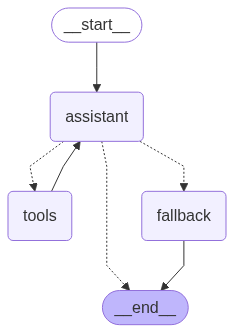

In [ ]:
from IPython.display import Image, display

try:
    display(Image(fallback_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Here we use LangGraph's `invoke` rather than streaming assistant messages, so that the original Agent's response (which was prevented via our trustworthiness-based fallback) is not printed.

In [ ]:
incomplete_tool = "What are the details of the 5 discount plan"

result = fallback_graph.invoke(
    {"messages": ("user", incomplete_tool)},
    RunnableConfig(configurable={"passenger_id": "3442 587242"})
)

messages = result.get("messages", [])
_printed = set()
for message in messages:
    if message.id not in _printed:
        msg_repr = message.pretty_repr(html=True)
        print(msg_repr)
        _printed.add(message.id)

================================ Human Message =================================

What are the details of the 5 discount plan
================================== Ai Message ==================================
Tool Calls:
  get_discount_plan (call_y9M9og2WxQdpnp43ImABJxHW)
 Call ID: call_y9M9og2WxQdpnp43ImABJxHW
  Args:
    name: five
================================= Tool Message =================================
Name: get_discount_plan

Returning details for the 'five' discount plan:
================================== Ai Message ==================================

I'm not confident in answering this question. Let's try something else or rephrase the question.


In this case, the trustworthiness-based fallback prevented the Agent from hallucinating incorrect details about the "five" discount plan; it instead now responds with a fallback message, which is significantly preferrable over an incorrect response returned by the original Agent for this query.

**In conclusion,** adding trustworthiness scoring to your Agent is easy and can automatically prevent your Agent from delivering misleading/incorrect responses to users.